# Query-Feature-Based Routing Heuristic

### Model Training

In [70]:
import time
import json
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuration
exclude_percentile = 80  # Removes the top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json('../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl', orient='records', lines=True)

# Filter out the top X% most complex queries
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Keep only relevant columns for Training
train_df = train_df[['id', 'query', 'instruction', 'input', 
                     'query_chars_count', 'query_words_count', 'query_unique_word_count', 
                     'query_readability_score', 'query_special_tokens_count', 
                     'query_keywords_count', 'query_contains_url', 'category', 'query_complexity_score']]

# Extract X and Y for Training
X_train_category = train_df[['query']]
y_train_category = train_df['category']

X_train_complexity = train_df.drop(columns=['id', 'query_complexity_score'])
y_train_complexity = train_df['query_complexity_score']

# Train category model
preprocessor_category = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=5500), 'query')
])

pipeline_category = Pipeline([
    ('preprocessor', preprocessor_category),
    ('classifier', LogisticRegression(max_iter=1000, C=1, solver='lbfgs', penalty='l2'))
])

start_time = time.time()
pipeline_category.fit(X_train_category, y_train_category)
end_time = time.time()
category_train_time = end_time - start_time

# Save category model with percentile in filename
category_model_filename = f"category_model_p{exclude_percentile}.pkl"
joblib.dump(pipeline_category, category_model_filename)
print(f"Category Model Trained in {category_train_time:.4f} seconds.")
print(f"Saved as: {category_model_filename}")

# Train complexity score model
preprocessor_complexity = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=5000), 'query'),
    ('num', StandardScaler(), ['query_chars_count', 'query_words_count', 'query_unique_word_count', 
                               'query_readability_score', 'query_special_tokens_count', 
                               'query_keywords_count', 'query_contains_url']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['category'])
])

pipeline_complexity = Pipeline([
    ('preprocessor', preprocessor_complexity),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, n_jobs=-1, random_state=42))
])

start_time = time.time()
pipeline_complexity.fit(X_train_complexity, y_train_complexity)
end_time = time.time()
complexity_train_time = end_time - start_time

# Save complexity model with percentile in filename
complexity_model_filename = f"/trained_models/complexity_model_p{exclude_percentile}_nest100.pkl"
joblib.dump(pipeline_complexity, complexity_model_filename)
print(f"Complexity Score Model Trained in {complexity_train_time:.4f} seconds.")
print(f"Saved as: {complexity_model_filename}")


Filtered out the top 0% most complex queries.
Total queries removed: 0. Remaining for training/testing: 50000.
Final split: 45000 queries for training, 5000 queries for testing.
Category Model Trained in 17.4603 seconds.
Saved as: approach_1_pretrained_models/category_model_p100.pkl
Complexity Score Model Trained in 273.4717 seconds.
Saved as: approach_1_pretrained_models/complexity_model_p100_nest100.pkl


### Model Testing for Category Prediction + Feature Calculation + Score Prediction

In [17]:
import re
import time
import json
import joblib
import pandas as pd
from textstat import textstat
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json('../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl', orient='records', lines=True)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Load pretrained models
pipeline_category = joblib.load("trained_models/category_model_p80.pkl")
pipeline_complexity = joblib.load("trained_models/complexity_model_p80_nest100.pkl")

# Prepare testing data
test_df = test_df[['id', 'query', 'instruction', 'input']]

print(f"Loaded {len(test_df)} queries for testing.")


# --- CATEGORY PREDICTION ---
test_X_category = test_df[['query']]

start_time = time.time()
y_pred_category = pipeline_category.predict(test_X_category)
end_time = time.time()

category_test_time = end_time - start_time
average_time_per_query_category = category_test_time / len(test_df)

print(f"Category Prediction Completed in {category_test_time:.4f} seconds.")
print(f"Avg Time per Query for Category Prediction: {average_time_per_query_category:.6f} seconds.")

# Append predicted categories to test_df
test_df['predicted_category'] = y_pred_category

def calculate_query_features(df):
    """
    Extracts query-based features such as length, special tokens, keywords, and readability.

    Args:
        df (pd.DataFrame): DataFrame containing queries.

    Returns:
        pd.DataFrame: Updated DataFrame with additional query-based features.
    """
    special_tokens = [":", ";", "=", "+", "-", "_", "/", ".", "'", '"', "´", "`", ",", "<", ">", "[", "]", "{", "}", "(", ")", "?", "!", "*", "&", "$", "#", "@", "%", "^", "~", "|", "\\"]
    keywords = [
        "analyze", "synthesize", "interpret", "evaluate", "justify", "compare", 
        "optimize", "hypothesize", "formulate", "simulate", "derive", "describe",
        "validate", "correlate", "quantify", "investigate", "predict", "forecast",
        "prove", "assess", "criticize", "argue", "solve", "reconstruct", "theorize",
        "explore", "elaborate", "deduce", "refute", "conceptualize", "identify", "outline",
        "rationalize", "articulate", "summarize", "innovate", "extrapolate", "explain", "clarify"
    ]

    def remove_urls(text):
        """
        Removes URLs and image links from a given text.

        Args:
            text (str): The input text.

        Returns:
            str: The cleaned text without URLs.
        """
        return re.sub(r'!\[.*?\]\(.*?\)|http[s]?://\S+', '', text)

    # Apply transformations row-wise
    df['query_chars_count'] = df['query'].apply(lambda x: len(str(x)))
    df['query_words_count'] = df['query'].apply(lambda x: len(str(x).split()))
    df['query_unique_word_count'] = df['query'].apply(lambda x: len(set(str(x).split())))
    df['query_readability_score'] = df['query'].apply(lambda x: textstat.flesch_kincaid_grade(remove_urls(x)))
    df['query_special_tokens_count'] = df['query'].apply(lambda x: sum(1 for char in str(x) if char in special_tokens))
    df['query_keywords_count'] = df.apply(lambda row: (
        sum(len(re.findall(r'\b{}\b'.format(re.escape(keyword)), str(row.get('instruction', '')).lower())) for keyword in keywords)
        if row.get('instruction') 
        else sum(len(re.findall(r'\b{}\b'.format(re.escape(keyword)), str(row.get('input', '')).lower())) for keyword in keywords)
        ), axis=1)
    df['query_contains_url'] = df['query'].apply(lambda x: int(bool(re.search(r'http[s]?://', str(x)))))

    return df

start_time = time.time()
test_df = calculate_query_features(test_df)
end_time = time.time()

query_features_time = end_time - start_time
average_time_query_features = query_features_time / len(test_df)

print(f"Query Features Computed in {query_features_time:.4f} seconds.")

# Use predicted category as 'category'
test_df['category'] = test_df['predicted_category']  

# Use the same OneHotEncoder from the trained model
category_encoder = pipeline_complexity.named_steps['preprocessor'].transformers_[2][1]
category_encoded = category_encoder.transform(test_df[['category']]).toarray()

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=category_encoder.get_feature_names_out(['category']))

# Merge with test data
test_df = test_df.reset_index(drop=True)
test_df = pd.concat([test_df, category_encoded_df], axis=1)

# --- COMPLEXITY SCORE PREDICTION ---
features_to_drop = ['id', 'instruction', 'input', 'predicted_category']
test_X_complexity = test_df.drop(columns=features_to_drop, errors='ignore')

start_time = time.time()
y_pred_complexity = pipeline_complexity.predict(test_X_complexity)
end_time = time.time()

complexity_test_time = end_time - start_time
average_time_per_query_complexity = complexity_test_time / len(test_df)

print(f"Complexity Score Prediction Completed in {complexity_test_time:.4f} seconds.")

# Store predictions in test_df
test_df['predicted_complexity_score'] = y_pred_complexity

# --- FINAL TIME SUMMARY ---
total_inference_time = category_test_time + query_features_time + complexity_test_time
avg_time_per_query = total_inference_time / len(test_df)

print(f"Total Inference Time: {total_inference_time:.4f} seconds")
print(f"Avg Inference Time per Query: {avg_time_per_query:.6f} seconds")

# --- RESTORE ACTUAL LABELS FOR EVALUATION ---
test_df['category'] = filtered_df.iloc[num_train:]['category'].values
test_df['query_complexity_score'] = filtered_df.iloc[num_train:]['query_complexity_score'].values

# --- CATEGORY MODEL EVALUATION ---
category_accuracy = accuracy_score(test_df['category'], test_df['predicted_category'])
category_report = classification_report(test_df['category'], test_df['predicted_category'], zero_division=0)

print("\nCATEGORY MODEL EVALUATION")
print(f"Category Prediction Accuracy: {category_accuracy * 100:.2f}%")
print("\nClassification Report:\n", category_report)

# --- COMPLEXITY SCORE MODEL EVALUATION ---
complexity_mse = mean_squared_error(test_df['query_complexity_score'], test_df['predicted_complexity_score'])
complexity_mae = mean_absolute_error(test_df['query_complexity_score'], test_df['predicted_complexity_score'])
complexity_r2 = r2_score(test_df['query_complexity_score'], test_df['predicted_complexity_score'])

print("\nCOMPLEXITY SCORE MODEL EVALUATION")
print(f"Complexity Score Prediction MSE: {complexity_mse:.4f}")
print(f"Complexity Score Prediction MAE: {complexity_mae:.4f}")
print(f"Complexity Score Prediction R2 Score: {complexity_r2:.4f}")


Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.
Loaded 4000 queries for testing.
Category Prediction Completed in 0.0952 seconds.
Avg Time per Query for Category Prediction: 0.000024 seconds.
Query Features Computed in 2.2809 seconds.
Complexity Score Prediction Completed in 0.2055 seconds.
Total Inference Time: 2.5817 seconds
Avg Inference Time per Query: 0.000645 seconds

CATEGORY MODEL EVALUATION
Category Prediction Accuracy: 75.25%

Classification Report:
                             precision    recall  f1-score   support

    Comparative/Analytical       0.50      0.17      0.25        42
  Creative Text Generation       0.83      0.84      0.83       297
   Dialogue/Conversational       0.86      0.08      0.14        79
Factual Question Answering       0.81      0.83      0.82      1433
   General Advice/Personal       0.72      0.88      0.79   

###  Model Testing for Category Prediction + Feature Calculation + Score Calculation

In [29]:
import pandas as pd
import time
import json
import re
import joblib
from textstat import textstat
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json('../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl', orient='records', lines=True)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Load Trained Category Model
pipeline_category = joblib.load("trained_models/category_model_p80.pkl")

# --- CATEGORY PREDICTION ---
test_X_category = test_df[['query']]

start_time = time.time()
y_pred_category = pipeline_category.predict(test_X_category)
end_time = time.time()

category_test_time = end_time - start_time
average_time_per_query_category = category_test_time / len(test_df)

print(f"Category Prediction Completed in {category_test_time:.4f} seconds.")
print(f"Avg Time per Query for Category Prediction: {average_time_per_query_category:.6f} seconds.")

# Append predicted categories to test_df
test_df['predicted_category'] = y_pred_category

# --- COMPUTE QUERY FEATURES ---
def calculate_query_features(df):
    """
    Extracts query-based features such as length, special tokens, keywords, and readability.

    Args:
        df (pd.DataFrame): DataFrame containing queries.

    Returns:
        pd.DataFrame: Updated DataFrame with additional query-based features.
    """
    special_tokens = [":", ";", "=", "+", "-", "_", "/", ".", "'", '"', "´", "`", ",", "<", ">", "[", "]", "{", "}", "(", ")", "?", "!", "*", "&", "$", "#", "@", "%", "^", "~", "|", "\\"]
    keywords = [
        "analyze", "synthesize", "interpret", "evaluate", "justify", "compare", 
        "optimize", "hypothesize", "formulate", "simulate", "derive", "describe",
        "validate", "correlate", "quantify", "investigate", "predict", "forecast",
        "prove", "assess", "criticize", "argue", "solve", "reconstruct", "theorize",
        "explore", "elaborate", "deduce", "refute", "conceptualize", "identify", "outline",
        "rationalize", "articulate", "summarize", "innovate", "extrapolate", "explain", "clarify"
    ]

    def remove_urls(text):
        """
        Removes URLs and image links from a given text.

        Args:
            text (str): The input text.

        Returns:
            str: The cleaned text without URLs.
        """
        return re.sub(r'!\[.*?\]\(.*?\)|http[s]?://\S+', '', text)

    df['query_chars_count'] = df['query'].str.len()
    df['query_words_count'] = df['query'].str.split().str.len()
    df['query_unique_word_count'] = df['query'].apply(lambda x: len(set(str(x).split())))
    df['query_readability_score'] = df['query'].apply(lambda x: textstat.flesch_kincaid_grade(remove_urls(str(x))))
    df['query_special_tokens_count'] = df['query'].apply(lambda x: sum(1 for char in str(x) if char in special_tokens))
    df['query_keywords_count'] = df.apply(lambda row: (
        sum(len(re.findall(r'\b{}\b'.format(re.escape(keyword)), str(row.get('instruction', '')).lower())) for keyword in keywords)
        if row.get('instruction') 
        else sum(len(re.findall(r'\b{}\b'.format(re.escape(keyword)), str(row.get('input', '')).lower())) for keyword in keywords)
    ), axis=1)    
    df['query_contains_url'] = df['query'].str.contains(r'http[s]?://').astype(int)

    return df

start_time = time.time()
test_df = calculate_query_features(test_df)
end_time = time.time()
query_features_time = end_time - start_time
average_time_query_features = query_features_time / len(test_df)

print(f"Query Features Computed in {query_features_time:.4f} seconds.")

# --- COMPUTE COMPLEXITY SCORE USING HEURISTIC ---

# Normalized category weights based on subjective assessment of complexity
category_weights = {
    "Mathematics/Problem Solving": 1.0,
    "Coding/Programming": 0.9,
    "Reasoning/Logic": 0.85,
    "Summarization/Paraphrasing": 0.75,
    "Comparative/Analytical": 0.7,
    "Creative Text Generation": 0.6,
    "Open-ended/Opinion-based": 0.5,
    "Recommendation Systems": 0.45,
    "General Advice/Personal": 0.4,
    "Dialogue/Conversational": 0.35,
    "Factual Question Answering": 0.3,
    "Instruction Following": 0.25,
    "Translation": 0.2,
    "Miscellaneous/Other": 0.15,
}

# Heuristic weights
weights = {
    "category": 2.5,
    "length": 1.0,
    "unique": 0.4,
    "readability": 1.2,
    "special_tokens": 0.9,
    "keywords": 1.5,
    "url_presence": 1.0,
}

# Calculate min and max values for each feature using training set (feature_df)
feature_min_max = {
    "query_chars_count": (train_df['query_chars_count'].min(), train_df['query_chars_count'].max()),
    "query_words_count": (train_df['query_words_count'].min(), train_df['query_words_count'].max()),
    "query_unique_word_count": (train_df['query_unique_word_count'].min(), train_df['query_unique_word_count'].max()),
    "query_readability_score": (train_df['query_readability_score'].min(), 20),  # Cap readability at 20
    "query_special_tokens_count": (train_df['query_special_tokens_count'].min(), train_df['query_special_tokens_count'].max()),
    "query_keywords_count": (train_df['query_keywords_count'].min(), train_df['query_keywords_count'].max()),
}

def min_max_scaling(series, min_value, max_value):
    """
    Applies Min-Max scaling to normalize values within a specified range.

    Args:
        series (pd.Series): The input series containing numerical values.
        min_value (float): The minimum value in the range for scaling.
        max_value (float): The maximum value in the range for scaling.

    Returns:
        pd.Series: The normalized series where values are scaled between 0 and 1.
    """
    return (series - min_value) / (max_value - min_value)

def calculate_complexity_df(df):
    """
    Computes the complexity score based on predefined heuristic weights.

    Args:
        df (pd.DataFrame): DataFrame containing query features.

    Returns:
        pd.Series: Computed complexity scores.
    """
    category_weight = df['predicted_category'].map(category_weights).fillna(0.03)

    length_score = (
        min_max_scaling(df['query_chars_count'], *feature_min_max['query_chars_count']) +
        min_max_scaling(df['query_words_count'], *feature_min_max['query_words_count'])
    ) / 2

    unique_score = min_max_scaling(df['query_unique_word_count'], *feature_min_max['query_unique_word_count'])
    readability_score = min_max_scaling(
        df['query_readability_score'].clip(upper=feature_min_max['query_readability_score'][1]),
        *feature_min_max['query_readability_score']
    )
    special_tokens_score = min_max_scaling(df['query_special_tokens_count'], *feature_min_max['query_special_tokens_count'])
    keywords_score = min_max_scaling(df['query_keywords_count'], *feature_min_max['query_keywords_count'])

    complexity_score = (
        weights['category'] * category_weight +
        weights['length'] * length_score +
        weights['unique'] * unique_score +
        weights['readability'] * readability_score +
        weights['special_tokens'] * special_tokens_score +
        weights['keywords'] * keywords_score +
        weights['url_presence'] * df['query_contains_url']
    )

    return complexity_score.round(4)

start_time = time.time()
test_df['calculated_complexity_score'] = calculate_complexity_df(test_df)
end_time = time.time()
complexity_calc_time = end_time - start_time

print(f"Complexity Score Calculation Completed in {complexity_calc_time:.4f} seconds.")

# Final time summary
total_inference_time = category_test_time + query_features_time + complexity_calc_time
avg_time_per_query = total_inference_time / len(test_df)

print(f"Total Inference Time: {total_inference_time:.4f} seconds")
print(f"Avg Inference Time per Query: {avg_time_per_query:.6f} seconds")

# Restore actual labels for evaluation
test_df['category'] = filtered_df.iloc[num_train:]['category'].values
test_df['query_complexity_score'] = filtered_df.iloc[num_train:]['query_complexity_score'].values

# Category model evaluation
category_accuracy = accuracy_score(test_df['category'], test_df['predicted_category'])
category_report = classification_report(test_df['category'], test_df['predicted_category'], zero_division=0)

print("\nCATEGORY MODEL EVALUATION")
print(f"Category Prediction Accuracy: {category_accuracy * 100:.2f}%")
print("\nClassification Report:\n", category_report)

# Complexity score model evaluation
complexity_mse = mean_squared_error(test_df['query_complexity_score'], test_df['calculated_complexity_score'])
complexity_mae = mean_absolute_error(test_df['query_complexity_score'], test_df['calculated_complexity_score'])
complexity_r2 = r2_score(test_df['query_complexity_score'], test_df['calculated_complexity_score'])

print("\nCOMPLEXITY SCORE MODEL EVALUATION")
print(f"Complexity Score Calculation MSE: {complexity_mse:.4f}")
print(f"Complexity Score Calculation MAE: {complexity_mae:.4f}")
print(f"Complexity Score Calculation R2 Score: {complexity_r2:.4f}")

# Define output file path
output_file_path = 'calculated_complexity.jsonl'

# Write DataFrame to a JSONL file
with open(output_file_path, 'w') as output_file:
    for entry in test_df[['id', 'calculated_complexity_score']].to_dict(orient='records'):
        json.dump(entry, output_file, separators=(",", ":"))
        output_file.write('\n')

print(f"Dataset with calculated complexity scores saved to: {output_file_path}")


Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.
Category Prediction Completed in 0.0618 seconds.
Avg Time per Query for Category Prediction: 0.000015 seconds.
Query Features Computed in 1.7423 seconds.
Complexity Score Calculation Completed in 0.0078 seconds.
Total Inference Time: 1.8119 seconds
Avg Inference Time per Query: 0.000453 seconds

CATEGORY MODEL EVALUATION
Category Prediction Accuracy: 75.25%

Classification Report:
                             precision    recall  f1-score   support

    Comparative/Analytical       0.50      0.17      0.25        42
  Creative Text Generation       0.83      0.84      0.83       297
   Dialogue/Conversational       0.86      0.08      0.14        79
Factual Question Answering       0.81      0.83      0.82      1433
   General Advice/Personal       0.72      0.88      0.79      1410
     Instruction Followi

### Evaluation

Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.

=== Routing Evaluation for Quantiles (20-40-60) ===
  - Low Complexity (Base)     : <= 1.2878
  - Medium Complexity (Large) : > 1.2878 and <= 1.4139
  - High Complexity (XL)      : > 1.4139

--- Routing Heuristic Evaluation ---
Quality Loss compared to GT: -6.48%
Quality Loss compared to XL: -3.67%
Compute Savings compared to GT: 8.90%
Compute Savings compared to XL: 33.13%
Routing Accuracy: 48.83%
Total Compute Units Used: 32096.00 CUs
Avg Routing Time per Query: 0.00000060 seconds
Number of queries routed to Base: 800
Number of queries routed to Large: 800
Number of queries routed to XL: 2400

Classification Report:
              precision    recall  f1-score   support

        Base       0.21      0.30      0.24       552
       Large       0.18      0.19      0.18       754
          XL       0.69     

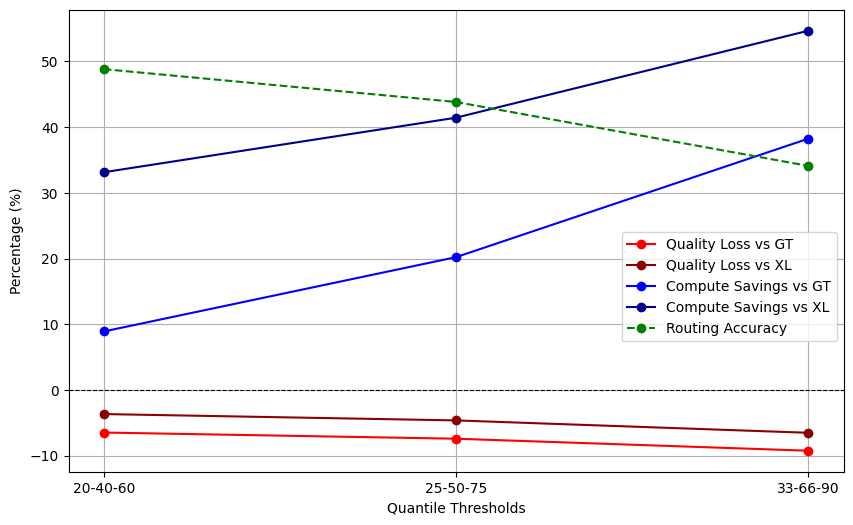

Plot saved in '../../plots/evaluation_query_feature_routing.pdf'


In [15]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json('../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl',orient='records', lines=True)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Load complexity scores from saved file
complexity_scores_df = pd.read_json('calculated_complexity.jsonl', orient='records', lines=True)

# Merge complexity scores with test data
test_df = test_df.merge(complexity_scores_df, on='id', how='left')

# Check if merge worked
if 'calculated_complexity_score' not in test_df.columns:
    raise KeyError("Error: 'calculated_complexity_score' is missing after merging!")

# Define compute unit consumption for each model
COMPUTE_UNITS = {1: 1.0, 2: 3.12, 3: 12.0}

# Define different quantile threshold configurations
quantile_settings = [
    (0.20, 0.40, 0.60),  # 20th, 40th, 60th percentiles
    (0.25, 0.50, 0.75),  # 25th, 50th, 75th percentiles
    (0.33, 0.66, 0.90),  # 33rd, 66th, 90th percentiles
]

# Lists for storing evaluation metrics
quality_loss_gt_list = []
quality_loss_xl_list = []
compute_savings_gt_list = []
compute_savings_xl_list = []
accuracy_list = []
routing_time_list = []
quantile_labels = ["20-40-60", "25-50-75", "33-66-90"]

def calculate_quality_discrepancies(df):
    """
    Calculates the quality loss compared to the ground truth (GT) and XL model.

    Args:
        df (pd.DataFrame): The test dataset containing query results and model labels.

    Returns:
        tuple: (quality_loss_to_gt, quality_loss_to_xl)
    """
    total_score_gt = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['evaluation_model_label'] - 1]}"], axis=1).sum()
    total_score_router = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['routed_to'] - 1]}"], axis=1).sum()
    total_score_xl = df['avg_normalized_score_t5_xl'].sum()

    num_queries = len(df)

    avg_score_gt = total_score_gt / num_queries
    avg_score_router = total_score_router / num_queries
    avg_score_xl = total_score_xl / num_queries

    quality_loss_to_gt = ((avg_score_router - avg_score_gt) / avg_score_gt) * 100
    quality_loss_to_xl = ((avg_score_router - avg_score_xl) / avg_score_xl) * 100

    return quality_loss_to_gt, quality_loss_to_xl

def calculate_compute_unit_discrepancies(df):
    """
    Calculates compute savings compared to GT and XL model.

    Args:
        df (pd.DataFrame): The test dataset with routed model labels.

    Returns:
        tuple: (compute_savings_to_gt, compute_savings_to_xl, total_compute_units_router)
    """
    total_compute_units_gt = sum(df['evaluation_model_label'].map(COMPUTE_UNITS))
    total_compute_units_router = sum(df['routed_to'].map(COMPUTE_UNITS))
    total_compute_units_xl = len(df) * COMPUTE_UNITS[3]

    compute_savings_to_gt = ((total_compute_units_gt - total_compute_units_router) / total_compute_units_gt) * 100
    compute_savings_to_xl = ((total_compute_units_xl - total_compute_units_router) / total_compute_units_xl) * 100

    return compute_savings_to_gt, compute_savings_to_xl, total_compute_units_router

# Iterate over quantile settings
for low_q, mid_q, high_q in quantile_settings:
    # Compute thresholds
    low_threshold = test_df['calculated_complexity_score'].quantile(low_q)
    high_threshold = test_df['calculated_complexity_score'].quantile(mid_q)

    print(f"\n=== Routing Evaluation for Quantiles ({int(low_q*100)}-{int(mid_q*100)}-{int(high_q*100)}) ===")
    print(f"  - Low Complexity (Base)     : <= {low_threshold:.4f}")
    print(f"  - Medium Complexity (Large) : > {low_threshold:.4f} and <= {high_threshold:.4f}")
    print(f"  - High Complexity (XL)      : > {high_threshold:.4f}")

    # Define routing function
    def route_by_quantile(complexity_score):
        """
        Routes a query to a model based on its calculated complexity score.

        Args:
            complexity_score (float): The complexity score of a query.

        Returns:
            int: The selected model (1 = base, 2 = large, 3 = xl).
        """
        if complexity_score > high_threshold:
            return 3  # Route to t5_xl
        elif complexity_score > low_threshold:
            return 2  # Route to t5_large
        else:
            return 1  # Route to t5_base

    # Apply routing and measure time
    start_time = time.time()
    test_df['routed_to'] = test_df['calculated_complexity_score'].apply(route_by_quantile)
    end_time = time.time()
    routing_time = end_time - start_time
    avg_routing_time_per_query = routing_time / len(test_df)
    
    # Count queries routed to each model
    num_routed_base = (test_df['routed_to'] == 1).sum()
    num_routed_large = (test_df['routed_to'] == 2).sum()
    num_routed_xl = (test_df['routed_to'] == 3).sum()
    
    # Compute metrics
    quality_loss_gt, quality_loss_xl = calculate_quality_discrepancies(test_df)
    compute_savings_gt, compute_savings_xl, compute_units_router = calculate_compute_unit_discrepancies(test_df)
    accuracy = accuracy_score(test_df['evaluation_model_label'], test_df['routed_to']) * 100

    # Store values for visualization
    quality_loss_gt_list.append(quality_loss_gt)
    quality_loss_xl_list.append(quality_loss_xl)
    compute_savings_gt_list.append(compute_savings_gt)
    compute_savings_xl_list.append(compute_savings_xl)
    accuracy_list.append(accuracy)
    routing_time_list.append(avg_routing_time_per_query)

    # Print final evaluation metrics
    print("\n--- Routing Heuristic Evaluation ---")
    print(f"Quality Loss compared to GT: {quality_loss_gt:.2f}%")
    print(f"Quality Loss compared to XL: {quality_loss_xl:.2f}%")
    print(f"Compute Savings compared to GT: {compute_savings_gt:.2f}%")
    print(f"Compute Savings compared to XL: {compute_savings_xl:.2f}%")
    print(f"Routing Accuracy: {accuracy:.2f}%")
    print(f"Total Compute Units Used: {compute_units_router:.2f} CUs")
    print(f"Avg Routing Time per Query: {avg_routing_time_per_query:.8f} seconds")
    print(f"Number of queries routed to Base: {num_routed_base}")
    print(f"Number of queries routed to Large: {num_routed_large}")
    print(f"Number of queries routed to XL: {num_routed_xl}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_df['evaluation_model_label'], test_df['routed_to'], target_names=["Base", "Large", "XL"], zero_division=0))

# Visualization
print("Quality Loss, Compute Savings, and Routing Accuracy for Query-Feature-Based Routing")
plt.figure(figsize=(10, 6))

# Quality Loss (Red)
plt.plot(quantile_labels, quality_loss_gt_list, marker='o', label="Quality Loss vs GT", color="red")
plt.plot(quantile_labels, quality_loss_xl_list, marker='o', label="Quality Loss vs XL", color="darkred")

# Compute Savings (Blue)
plt.plot(quantile_labels, compute_savings_gt_list, marker='o', label="Compute Savings vs GT", color="blue")
plt.plot(quantile_labels, compute_savings_xl_list, marker='o', label="Compute Savings vs XL", color="darkblue")

# Accuracy (Green)
plt.plot(quantile_labels, accuracy_list, marker='o', label="Routing Accuracy", color="green", linestyle="--")

# Labels & Styling
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xlabel("Quantile Thresholds")
plt.ylabel("Percentage (%)")
plt.title('')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.4), frameon=True)
plt.grid(True)

# Save the figure as a PDF file
plt.savefig('../../plots/evaluation_query_feature_routing.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the plot to avoid display issues in automated scripts
plt.close()

print("Plot saved in '../../plots/evaluation_query_feature_routing.pdf'")
